# Projeto de SuperComputação - Insper - 2023.2

### Autor: Renato Laffranchi Falcão

Este relatório tem como objetivo apresentar três diferentes soluções para o Problema do Clique Máximo: abordagem exaustiva, abordagem exaustiva paralelizada com OpenMP e abordagem exaustiva distribuída entre nós de um cluster com MPI.

## Instalação e importação de dependências

In [9]:
import subprocess
import time
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import multiprocessing

## Funções de suporte

In [10]:
def graph_generator(num_vertices = 50, conection_prob = 0.5, filename = "graph.txt", verbose = True):
    """
    Arguments:
    num_vertices: number of vertices in the graph
    conection_prob: probability of connection between two vertices
    filename: name of the output file
    verbose: if True, prints when the graph is generated and saved
    """

    # Create a random graph
    graph = nx.fast_gnp_random_graph(num_vertices, conection_prob)

    # Write the graph to a file
    with open(f"files/{filename}", "w") as file:
        # Header line with number of vertices and edges
        file.write(f"{num_vertices} {graph.number_of_edges()}\n")

        # Write the edges in the file
        for aresta in graph.edges():
            # +1 to convert from 0-indexed to 1-indexed
            file.write(f"{aresta[0]+1} {aresta[1]+1}\n")

    if verbose:
        print(f"Graph generated and saved in {filename}")

    return 0

def graph_verifier(read_file_name = "graph.txt", write_file_name = "graph_cliques.txt", verbose = True):
    """
    Arguments:
    read_file_name: name of the file to read the graph from
    write_file_name: name of the file to write the results to
    verbose: if True, prints the maximals and maximum cliques found
    """

    # Open the file to read the graph
    with open(f"files/{read_file_name}", "r") as file:
        # Skip header line
        next(file)

        # Read the graph from the file to a networkx graph
        G = nx.parse_adjlist(file)

    # Find all maximal cliques
    maximal_cliques = list(nx.find_cliques(G))
    for clique in maximal_cliques:
        clique.sort(key=int)
    sorted_maximal_cliques = sorted(maximal_cliques, key=len, reverse=True)

    # Find the maximum clique (the longest one)
    # maximum_clique = max(maximal_cliques, key=len)
    maximum_clique = sorted_maximal_cliques[0]

    # Find all maximum cliques (the ones with the same length as the maximum clique)
    maximum_clique_size = len(maximum_clique)
    maximum_cliques = []
    for clique in sorted_maximal_cliques:
        if len(clique) != maximum_clique_size:
            break
        maximum_cliques.append(clique)

    # Open the file to write the results
    with open(f"files/{write_file_name}", "w") as file:
        file.write("Maximal Cliques found:\n")
        for clique in sorted_maximal_cliques:
            file.write(f"{clique}\n")
        file.write(f"\Maximum Clique found: {maximum_clique}\n")

    if verbose:
        print("Other maximum cliques found:")
        for clique in maximum_cliques:
            print(clique)

    return maximum_clique_size

def graph_pipeline(num_vertices = 50, conection_prob = 0.5, verbose = False):
    """
    Arguments:
    num_vertices: number of vertices in the graph
    conection_prob: probability of connection between two vertices
    verbose: if True, prints when the graph is generated and saved
    """

    graph_generator(num_vertices, conection_prob, verbose = verbose)

    return graph_verifier(verbose = verbose)

def run_executable(executable, arg, mpi = False):
    """
    Arguments:
    executable: name of the executable to run
    arg: argument to pass to the executable
    """
    start = time.perf_counter()
    proc = subprocess.run([f"./src/{executable}", f"{arg}"], capture_output=False).check_returncode() if not mpi else subprocess.run(["mpirun", "-np", f"{multiprocessing.cpu_count()}", f"./src/{executable}", f"{arg}"], capture_output=False).check_returncode()
    end = time.perf_counter()
    return (end - start)

def run_on_slurm(executable, arg):
    """
    Arguments:
    executable: name of the slurm batch configuration file
    arg: argument to pass to the executable
    """
    start = time.perf_counter()
    proc = subprocess.run(["sbatch", "--wait", f"./src/{executable}.slurm", f"{arg}"]).check_returncode()
    end = time.perf_counter()
    return (end - start)

def save_results(time, num_vertices, algorithm):
    """
    Arguments:
    time: time it took to run the executable
    num_vertices: number of vertices in the graph
    algorithm: name of the algorithm used
    """
    # Create a pandas dataframe with the results
    df = pd.DataFrame({"time": time, "num_vertices": num_vertices})
    # Save the dataframe to a feather file
    df.to_feather(f"results/results_{algorithm}.feather")

def run_and_save(algorithms, min_num_vertices, max_num_vertices, step, where_to_run = "slurm", mpi_algorithms = []):
    """
    Arguments:
    algorithms: name of the algorithms used
    slurm_files: name of the slurm batch configuration files
    min_num_vertices: minimum number of vertices in the graph
    max_num_vertices: maximum number of vertices in the graph
    step: step between the number of vertices processed
    where_to_run: where to run the executable, either "slurm" or "local"
    mpi_algorithms: list of algorithms that use MPI
    """

    if where_to_run not in ["slurm", "local"]:
        raise ValueError(f"Argument 'where_to_run' must be either 'slurm' or 'local', not {repr(where_to_run)}")

    function = run_on_slurm if where_to_run == "slurm" else run_executable
    
    for algorithm in algorithms:
        print("-+-"*30)
        print(f"Algorithm: {algorithm}")
        run_time = []
        run_num_vertices = []
        for graph_num_vertices in range(min_num_vertices, max_num_vertices+step, step):
            max_clique_size = graph_pipeline(num_vertices=graph_num_vertices, conection_prob=0.5)
            t = function(algorithm, max_clique_size) if where_to_run == "slurm" else function(algorithm, max_clique_size, mpi = algorithm in mpi_algorithms)
            run_time.append(t)
            run_num_vertices.append(graph_num_vertices)
        save_results(run_time, run_num_vertices, algorithm)
    print("-+-"*30)

def plot_results(algorithms):
    """
    Arguments:
    algorithms: name of the algorithms used
    """

    fig, ax = plt.subplots()
    for algorithm in algorithms:
        # Read the results from the corresponding feather file
        df = pd.read_feather(f"results/results_{algorithm}.feather")
        # Plot the results
        ax.plot(df["num_vertices"], df["time"], label=algorithm)
        ax.set( title="Algorithm Comparison", xlabel="Graph's Number of Vertices", ylabel="Execution time (s)")
        ax.legend(loc="best")
    fig.savefig(f"results/results.png")
    

In [11]:
!mkdir -p src/

## Abordagem Exaustiva

In [12]:
%%writefile src/recursive_exaustive.cpp
#include <iostream>
#include <vector>
#include <deque>
#include <fstream>
#include <algorithm>

// Author: Renato Laffranchi Falcão
// 12/2023

// This is a recursive implementation of the exaustive search algorithm for the maximum clique problem with backtracking optimization.
// The algorithm is based on the following paper:
// "A review on algorithms for maximum clique problems" by Qinghua Wu and Jin-Kao Hao. European Journal of Operational Research. Volume 242, Issue 3, 1 May 2015, Pages 693-709.
// http://dx.doi.org/10.1016/j.ejor.2014.09.064

std::vector<std::vector<int>> readGraph(const std::string& filename, int& numVertices)
// Module to read graph from file, provided as an adjacency matrix.
{
    std::ifstream file(filename);
    int numEdges;
    file >> numVertices >> numEdges;

    std::vector<std::vector<int>> graph(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numEdges; i++) {
        int u, v;
        file >> u >> v;
        // The graph is undirected, so we add the edge in both directions
        graph[u - 1][v - 1] = 1;
        graph[v - 1][u - 1] = 1;
    }

    file.close();

    return graph;
}

void clique(std::vector<int>& currentSolution, std::deque<int>& candidateVertices, std::vector<int>& maximumClique, std::vector<std::vector<int>>& graph)
// Recursive function to find the maximum clique
{
    // Update maximum clique found so far
    if ( currentSolution.size() > maximumClique.size() )
    {
        maximumClique = currentSolution;
    }

    // Backtracking optimization: if the size of the current solution plus the amount of
    // candidate vertices left is smaller than the size of the maximum clique found so far,
    // there is no need to continue
    if ((currentSolution.size() + candidateVertices.size()) <= maximumClique.size())
    {
        return;
    }

    // Creates a recursive call for each candidate vertex and its neighbors
    for (int u : candidateVertices)
    {
        candidateVertices.pop_front();
        std::vector<int> largerSolution(currentSolution);
        largerSolution.push_back(u);
        std::deque<int> neighborVertices;
        for (int v : candidateVertices)
        {
            if (graph[u][v] == 1)
            {
                neighborVertices.push_back(v);
            }
        }
        clique(largerSolution, neighborVertices, maximumClique, graph);
    }
    return;
}

std::vector<int> findMaximumClique()
// Main function to manage the execution of the algorithm
{
    // Read graph from file
    int numVertices;
    const std::string filename = "files/graph.txt";
    std::vector<std::vector<int>> graph = readGraph(filename, numVertices);

    // Create support data structures
    std::vector<int> maximumClique;
    std::vector<int> currentSolution;
    std::deque<int> candidateVertices;

    // Fill candidate vertices
    for (int i = 0; i < numVertices; i++)
    {
        candidateVertices.push_back(i);
    }

    // Find maximum clique
    clique(currentSolution, candidateVertices, maximumClique, graph);

    return maximumClique;
}

int main(int argc, char *argv[])
{
    // Find maximum clique
    std::vector<int> maximumClique = findMaximumClique();

    // Optional argument to check the correctness of the answer
    size_t correctAnswerLen = 0;

    if (argc > 1)
    {
        correctAnswerLen = atoi(argv[1]);
    }

    if (correctAnswerLen > 0 && maximumClique.size() != correctAnswerLen)
    {
        std::cout << "Wrong answer: clique size is " << maximumClique.size() << ", correct answer is " << correctAnswerLen << std::endl;
        return 1;
    }

    // Optional argument to print the maximum clique found
    bool verbose = false;

    if (argc > 2)
    {
        std::string arg = argv[2];
        if (arg == "-v" || arg == "--verbose")
        {
            verbose = true;
        }
    }

    if (verbose)
    {
        std::cout << "Maximum clique: ";
        for (int v : maximumClique)
        {
            // Print with corrected vertex index for comparison (starts at 1)
            std::cout << v+1 << " ";
        }
        std::cout << std::endl;
    }

    return 0;
}

Overwriting src/recursive_exaustive.cpp


## Solução paralelizada

In [13]:
%%writefile src/recursive_exaustive_parallel.cpp
#include <iostream>
#include <vector>
#include <deque>
#include <fstream>
#include <algorithm>
#include <omp.h>

// Author: Renato Laffranchi Falcão
// 12/2023

// This is a recursive implementation of the exaustive search algorithm for the maximum clique problem with backtracking optimization.
// The algorithm is based on the following paper:
// "A review on algorithms for maximum clique problems" by Qinghua Wu and Jin-Kao Hao. European Journal of Operational Research. Volume 242, Issue 3, 1 May 2015, Pages 693-709.
// http://dx.doi.org/10.1016/j.ejor.2014.09.064

std::vector<std::vector<int>> readGraph(const std::string& filename, int& numVertices)
// Module to read graph from file, provided as an adjacency matrix.
{
    std::ifstream file(filename);
    int numEdges;
    file >> numVertices >> numEdges;

    std::vector<std::vector<int>> graph(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numEdges; i++) {
        int u, v;
        file >> u >> v;
        // The graph is undirected, so we add the edge in both directions
        graph[u - 1][v - 1] = 1;
        graph[v - 1][u - 1] = 1;
    }

    file.close();

    return graph;
}

void clique(std::vector<int>& currentSolution, std::deque<int>& candidateVertices, std::vector<int>& maximumClique, std::vector<std::vector<int>>& graph)
// Recursive function to find the maximum clique
{
    // Update maximum clique found so far
    if ( currentSolution.size() > maximumClique.size() )
    {
        maximumClique = currentSolution;
    }

    // Backtracking optimization: if the size of the current solution plus the amount of
    // candidate vertices left is smaller than the size of the maximum clique found so far,
    // there is no need to continue
    if ((currentSolution.size() + candidateVertices.size()) <= maximumClique.size())
    {
        return;
    }

    // Creates a recursive call for each candidate vertex and its neighbors
    for (int u : candidateVertices)
    {
        candidateVertices.pop_front();
        std::vector<int> largerSolution(currentSolution);
        largerSolution.push_back(u);
        std::deque<int> neighborVertices;
        for (int v : candidateVertices)
        {
            if (graph[u][v] == 1)
            {
                neighborVertices.push_back(v);
            }
        }
        clique(largerSolution, neighborVertices, maximumClique, graph);
    }
    return;
}

std::vector<int> findMaximumClique()
// Main function to manage the execution of the algorithm
{
    // Read graph from file
    int numVertices;
    const std::string filename = "files/graph.txt";
    std::vector<std::vector<int>> graph = readGraph(filename, numVertices);

    // Create support data structures
    std::vector<int> maximumClique;
    std::deque<int> candidateVertices;

    // Fill candidate vertices
    for (int i = 0; i < numVertices; i++)
    {
        candidateVertices.push_back(i);
    }

    // For each candidate vertex, assign a thread
    // to find the maximum clique based on that vertex neighbors.
    #pragma omp parallel for schedule(dynamic)
    for (size_t u = 0; u < candidateVertices.size(); u++)
    {
        std::vector<int> localMaximumClique;
        std::vector<int> largerSolution;
        largerSolution.push_back(u);
        std::deque<int> neighborVertices;
        for (int v : candidateVertices)
        {
            if (graph[u][v] == 1)
            {
                neighborVertices.push_back(v);
            }
        }
        // Find maximum clique based on the neighbors of the candidate vertex
        clique(largerSolution, neighborVertices, localMaximumClique, graph);

        // Merge each thread results into the global maximum clique
        #pragma omp critical
        {
            if (localMaximumClique.size() > maximumClique.size())
            {
                maximumClique = localMaximumClique;
            }
        }
    }

    return maximumClique;
}

int main(int argc, char *argv[])
{
    // Find maximum clique
    std::vector<int> maximumClique = findMaximumClique();

    // Optional argument to check the correctness of the answer
    size_t correctAnswerLen = 0;

    if (argc > 1)
    {
        correctAnswerLen = atoi(argv[1]);
    }

    if (correctAnswerLen > 0 && maximumClique.size() != correctAnswerLen)
    {
        std::cout << "Wrong answer: clique size is " << maximumClique.size() << ", correct answer is " << correctAnswerLen << std::endl;
        return 1;
    }

    // Optional argument to print the maximum clique found
    bool verbose = false;

    if (argc > 2)
    {
        std::string arg = argv[2];
        if (arg == "-v" || arg == "--verbose")
        {
            verbose = true;
        }
    }

    if (verbose)
    {
        std::cout << "Maximum clique: ";
        for (int v : maximumClique)
        {
            // Print with corrected vertex index for comparison (starts at 1)
            std::cout << v+1 << " ";
        }
        std::cout << std::endl;
    }

    return 0;
}

Overwriting src/recursive_exaustive_parallel.cpp


## Solução para computação distribuída

In [31]:
%%writefile src/recursive_exaustive_distributed.cpp
#include <iostream>
#include <vector>
#include <deque>
#include <fstream>
#include <algorithm>
#include <mpi.h>

// Author: Renato Laffranchi Falcão
// 12/2023

// This is a recursive implementation of the exaustive search algorithm for the maximum clique problem with backtracking optimization.
// The algorithm is based on the following paper:
// "A review on algorithms for maximum clique problems" by Qinghua Wu and Jin-Kao Hao. European Journal of Operational Research. Volume 242, Issue 3, 1 May 2015, Pages 693-709.
// http://dx.doi.org/10.1016/j.ejor.2014.09.064

std::vector<std::vector<int>> readGraph(const std::string& filename, int& numVertices)
// Module to read graph from file, provided as an adjacency matrix.
{
    std::ifstream file(filename);
    int numEdges;
    file >> numVertices >> numEdges;

    std::vector<std::vector<int>> graph(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numEdges; i++) {
        int u, v;
        file >> u >> v;
        // The graph is undirected, so we add the edge in both directions
        graph[u - 1][v - 1] = 1;
        graph[v - 1][u - 1] = 1;
    }

    file.close();

    return graph;
}

void clique(std::vector<int>& currentSolution, std::deque<int>& candidateVertices, std::vector<int>& maximumClique, std::vector<std::vector<int>>& graph)
// Recursive function to find the maximum clique
{
    // Update maximum clique found so far
    if ( currentSolution.size() > maximumClique.size() )
    {
        maximumClique = currentSolution;
    }

    // Backtracking optimization: if the size of the current solution plus the amount of
    // candidate vertices left is smaller than the size of the maximum clique found so far,
    // there is no need to continue
    if ((currentSolution.size() + candidateVertices.size()) <= maximumClique.size())
    {
        return;
    }

    // Creates a recursive call for each candidate vertex and its neighbors
    for (int u : candidateVertices)
    {
        candidateVertices.pop_front();
        std::vector<int> largerSolution(currentSolution);
        largerSolution.push_back(u);
        std::deque<int> neighborVertices;
        for (int v : candidateVertices)
        {
            if (graph[u][v] == 1)
            {
                neighborVertices.push_back(v);
            }
        }
        clique(largerSolution, neighborVertices, maximumClique, graph);
    }
    return;
}

int main(int argc, char *argv[])
{
    // Initialize MPI
    MPI_Init(&argc, &argv);
    // rank: ID of process, from 0 to size-1, being "size" the total number of processes
    // size: The total number of processes
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Create variables to store graph data
    int numVertices;
    std::vector<std::vector<int>> graph;

    // Create vector to store maximum clique
    std::vector<int> maximumClique;

    if (rank == 0)
    {
        // Read graph from file
        const std::string filename = "files/graph.txt";
        graph = readGraph(filename, numVertices);
    }

    // Broadcast the number of vertices to all processes
    MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

    if (rank != 0)
    {
        // Processes resize the graph vector according to the number of vertices
        graph.resize(numVertices, std::vector<int>(numVertices));
    }

    // Broadcast the graph data to all processes
    for (int i = 0; i < numVertices; ++i) {
        MPI_Bcast(graph[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
    }

    // Main process (rank 0), assigns tasks to other processes
    if (rank == 0 && size > 1)
    {
        // Create deque of candidate vertices
        std::deque<int> candidateVertices;

        // Fill candidate vertices
        for (int i = 0; i < numVertices; i++)
        {
            candidateVertices.push_back(i);
        }

        // For each candidate vertex, commision a process
        // to find the maximum clique based on that vertex neighbors.
        int process = 1;
        for (size_t u = 0; u < candidateVertices.size(); u++)
        {
            // Create support vectors
            std::vector<int> currentSolution;
            std::vector<int> neighborVertices;

            // Add current vertex to solution
            currentSolution.push_back(u);

            // Add neighbors of current vertex to neighborVertices
            for (int v : candidateVertices)
            {
                if (graph[u][v] == 1)
                {
                    neighborVertices.push_back(v);
                }
            }

            // Serialize the size of vectors along with the data
            int currentSolutionSize = currentSolution.size();
            int neighborVerticesSize = neighborVertices.size();

            // Send size of currentSolution
            MPI_Send(&currentSolutionSize, 1, MPI_INT, process, process*10, MPI_COMM_WORLD);

            // Send currentSolution data
            MPI_Send(currentSolution.data(), currentSolutionSize, MPI_INT, process, process*11, MPI_COMM_WORLD);

            // Send size of neighborVertices
            MPI_Send(&neighborVerticesSize, 1, MPI_INT, process, process*12, MPI_COMM_WORLD);

            // Send neighborVertices data
            MPI_Send(neighborVertices.data(), neighborVerticesSize, MPI_INT, process, process*13, MPI_COMM_WORLD);

            // Move to the next process using Round-robin assignment
            process = (process % (size - 1)) + 1;
        }
    }

    // Other processes receive the data and execute the clique function
    else if (rank != 0)
    {
        // Receive size of currentSolution
        int currentSolutionSize;
        MPI_Recv(&currentSolutionSize, 1, MPI_INT, 0, rank*10, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Receive currentSolution data
        std::vector<int> currentSolution(currentSolutionSize);
        MPI_Recv(currentSolution.data(), currentSolutionSize, MPI_INT, 0, rank*11, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Receive size of neighborVertices
        int neighborVerticesSize;
        MPI_Recv(&neighborVerticesSize, 1, MPI_INT, 0, rank*12, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Receive neighborVertices data
        std::vector<int> neighborVerticesVector(neighborVerticesSize);
        MPI_Recv(neighborVerticesVector.data(), neighborVerticesSize, MPI_INT, 0, rank*13, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Casts neighborVertices to deque
        std::deque<int> neighborVertices(neighborVerticesVector.begin(), neighborVerticesVector.end());

        // Call clique function
        clique(currentSolution, neighborVertices, maximumClique, graph);

        // Send size of maximum clique found by process
        int maximumCliqueSize = maximumClique.size();
        MPI_Send(&maximumCliqueSize, 1, MPI_INT, 0, rank*14, MPI_COMM_WORLD);

        // Send maximumClique data
        MPI_Send(maximumClique.data(), maximumCliqueSize, MPI_INT, 0, rank*15, MPI_COMM_WORLD);
    }

    // Main process (rank 0) receives the data from other processes and finds the maximum clique
    if (rank == 0 && size > 1)
    {
        for (int process = 1; process < size; process++) {
            // Receive the size of the clique
            int receivedSize;
            MPI_Recv(&receivedSize, 1, MPI_INT, process, process*14, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

            // Receive the actual clique data
            std::vector<int> receivedClique(receivedSize);
            MPI_Recv(receivedClique.data(), receivedSize, MPI_INT, process, process*15, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

            // Update the overall maximum clique
            if (receivedSize > (int) maximumClique.size())
            {
                maximumClique = receivedClique;
            }
        }
    }

    if (rank == 0)
    {
        // In the event that there is only one process,
        // the main process will call the clique function.
        if (size == 1)
        {
            // Create support vector
            std::vector<int> currentSolution;

            // Create deque of candidate vertices
            std::deque<int> candidateVertices;

            // Fill candidate vertices
            for (int i = 0; i < numVertices; i++)
            {
                candidateVertices.push_back(i);
            }

            // Find maximum clique
            clique(currentSolution, candidateVertices, maximumClique, graph);
        }

        // Optional argument to check the correctness of the answer
        size_t correctAnswerLen = 0;

        if (argc > 1)
        {
            correctAnswerLen = atoi(argv[1]);
        }

        if (correctAnswerLen > 0 && maximumClique.size() != correctAnswerLen)
        {
            std::cout << "Wrong answer: clique size is " << maximumClique.size() << ", correct answer is " << correctAnswerLen << std::endl;
            return 1;
        }

        // Optional argument to print the maximum clique found
        bool verbose = false;

        if (argc > 2)
        {
            std::string arg = argv[2];
            if (arg == "-v" || arg == "--verbose")
            {
                verbose = true;
            }
        }

        if (verbose)
        {
            std::cout << "Maximum clique: ";
            for (int v : maximumClique)
            {
                // Print with corrected vertex index for comparison (starts at 1)
                std::cout << v+1 << " ";
            }
            std::cout << std::endl;
        }
    }

    MPI_Finalize();
    return 0;
}

Overwriting src/recursive_exaustive_distributed.cpp


## Compilação dos arquivos

A compilação dos arquivos em c++ pode ser feita através dos seguintes comandos:

In [32]:
!g++ -Wall -Ofast src/recursive_exaustive.cpp -o src/recursive_exaustive
!g++ -Wall -fopenmp -Ofast src/recursive_exaustive_parallel.cpp -o src/recursive_exaustive_parallel
!mpic++ src/recursive_exaustive_distributed.cpp -o src/recursive_exaustive_distributed

Para executar as implementações através do cluster montado em sala de aula, os seguinte arquivos de configuração de batch para Slurm foram utilizados, de forma a maximizar o uso do poder computacional disponível:

In [16]:
%%writefile src/recursive_exaustive.slurm
#!/bin/bash
#SBATCH --job-name=recursive_exaustive
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --partition=normal
#SBATCH --mem=3G
#SBATCH --output="outputs/recursive_exaustive_%j.out"

MAX_CLIQUE_SIZE=$1

echo "Job: $SLURM_JOB_ID"
./recursive_exaustive "$MAX_CLIQUE_SIZE" --verbose

Writing src/recursive_exaustive.slurm


In [17]:
%%writefile src/recursive_exaustive_parallel.slurm
#!/bin/bash
#SBATCH --job-name=recursive_exaustive_parallel
#SBATCH --nodes=2
#SBATCH --ntasks=3
#SBATCH --partition=normal
#SBATCH --mem=3G
#SBATCH --output="outputs/recursive_exaustive_parallel_%j.out"

MAX_CLIQUE_SIZE=$1

echo "Job: $SLURM_JOB_ID"
./recursive_exaustive_parallel "$MAX_CLIQUE_SIZE" --verbose

Writing src/recursive_exaustive_parallel.slurm


In [18]:
%%writefile src/recursive_exaustive_distributed.slurm
#!/bin/bash
#SBATCH --job-name=recursive_exaustive_distributed
#SBATCH --nodes=2
#SBATCH --ntasks=3
#SBATCH --partition=normal
#SBATCH --mem=3G
#SBATCH --output="outputs/recursive_exaustive_distributed_%j.out"

MAX_CLIQUE_SIZE=$1

echo "Job: $SLURM_JOB_ID"
mpirun ./recursive_exaustive_distributed "$MAX_CLIQUE_SIZE" --verbose

Writing src/recursive_exaustive_distributed.slurm


## Comparação dos resultados

In [33]:
!rm -rf files/
!mkdir files/
!rm -rf outputs/
!mkdir -p outputs/
!rm -rf results/
!mkdir -p results/

-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-
Algorithm: recursive_exaustive
-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-
Algorithm: recursive_exaustive_parallel
-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-


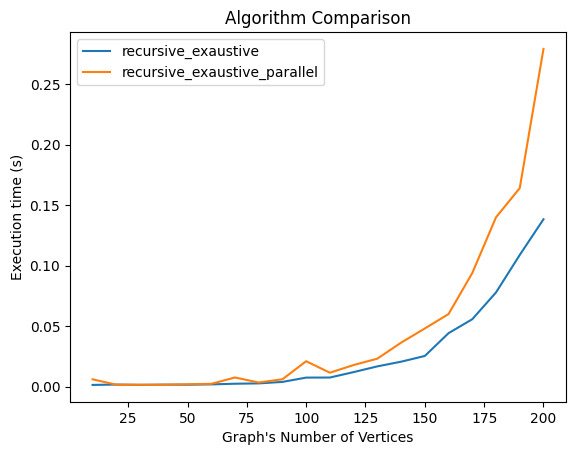

In [36]:
MIN_NUM_VERTICES = 10
MAX_NUM_VERTICES = 200
STEP = 10

# algorithms  = ["recursive_exaustive", "recursive_exaustive_parallel", "recursive_exaustive_distributed"]

algorithms  = ["recursive_exaustive", "recursive_exaustive_parallel"]

# run_and_save(algorithms, MIN_NUM_VERTICES, MAX_NUM_VERTICES, STEP, where_to_run = "slurm")
# run_and_save(algorithms, MIN_NUM_VERTICES, MAX_NUM_VERTICES, STEP, where_to_run = "local", mpi_algorithms = [algorithms[2]])
run_and_save(algorithms, MIN_NUM_VERTICES, MAX_NUM_VERTICES, STEP, where_to_run = "local")
plot_results(algorithms)

## Análise de soluções para o Problema do Clique Máximo

Os códigos apresentados implementam uma busca exaustiva recursiva para resolver o problema do clique máximo em grafos, utilizando OpenMP para paralelização e MPI para distribuição em nós de computação. A abordagem algorítmica, baseada no trabalho de Wu e Hao (2015), é robusta e promissora.

### Comparação entre implementações para diferentes tamanhos de grafos:

O gráfico acima demonstra o tempo de execução para diferentes tamanhos de grafos, tanto para as três versões implementadas.

Geralmente, espera-se que a execução paralela seja mais rápida que a sequencial. No entanto, neste caso, a paralelização com OpenMP resultou em desempenho inferior. Uma possível explicação é a presença de um alto grau de dependência entre os dados e as tarefas. O problema do clique máximo envolve muitas operações de leitura e escrita em estruturas de dados compartilhadas, o que pode levar a condições de corrida e consequente necessidade de sincronização e bloqueios, reduzindo a eficácia da paralelização.

Já para o

### Conclusão:

Os resultados obtidos destacam a complexidade de paralelizar algoritmos de busca exaustiva em grafos. Embora a teoria sugira um desempenho superior com paralelização, na prática, a eficácia depende significativamente da natureza do problema e da implementação específica do algoritmo. As observações acima oferecem insights sobre possíveis áreas de otimização e refinamento para melhor explorar o potencial da paralelização em problemas de grafos complexos.

![resultado](results/results.png)